In [1]:
import torch
import numpy as np
from model import UNet
from dataset import CarvanaDataset
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader


In [2]:
checkpoint = torch.load('checkpoint_overfit.pth')

In [3]:
model_ = UNet(3, 2)
model_.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
transforms_valid = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomCrop((350, 350)),
        transforms.Resize((512, 512), interpolation=0)
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512), interpolation=0)
    ]) 
}
data_folder = "/cache/fast_data_nas8/swetha"
val_dataset = CarvanaDataset(data_folder, mode="val", data_limit=10, transforms=transforms_valid)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

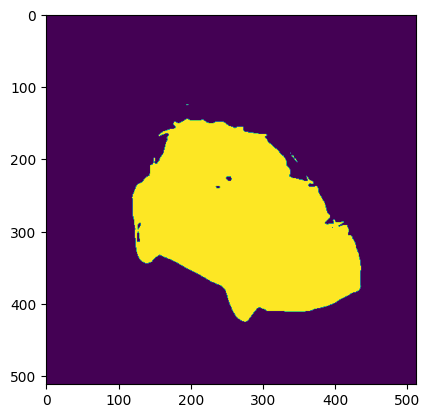

In [6]:
for img, mask in val_loader:
    predictions = model_(img)
    predictions_mask = torch.argmax(predictions, dim=1)
    mask_numpy = np.int64(mask)
    predictions_mask = np.int64(predictions_mask)
    plt.imshow(predictions_mask[0])

In [ ]:
predictions = model_(img)